In [1]:
import pandas as pd

df_clientes = pd.read_csv('clientes.csv', sep=';')
df_transacional = pd.read_csv('../downloads/transacional.csv', sep=';')

In [2]:
df_transacional.drop(columns = 'mob', inplace=True)


In [3]:
df_clientes.drop(columns = ['operadora_tim','operadora_claro','operadora_oi','operadora_vivo','operadora_nextel','operadora_others','sistema_operacional','reg_metropolitana','safra'], inplace=True)


In [4]:
from datetime import date
import numpy as np


ano_atual = date.today().year

df_clientes['idade'] = ano_atual - df_clientes['nascimento'].str[:4].astype(np.int64) 
    
df_clientes.drop(columns = ['nascimento'], inplace=True)


In [5]:
import category_encoders as ce

ce_OHE = ce.OneHotEncoder(cols=['genero_biologico','uf'])

df_clientes = ce_OHE.fit_transform(df_clientes)
df_clientes.head()

,uf_1,uf_2,uf_3,uf_4,uf_5,uf_6,uf_7,uf_8,uf_9,uf_10,...,uf_28,uf_29,genero_biologico_1,genero_biologico_2,renda_presumida,renda_declarada,limite_maximo,limite_global,id,idade
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1200.0,1800.0,0.0,0.0,1844674417714159308,28
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,750.0,1444.0,750.0,750.0,691752913106883469,28
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,4750.0,1000.0,11050.0,10050.0,461168608765220513,30
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,580.0,937.0,800.0,580.0,2075258704912373488,24
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1550.0,1460.0,0.0,0.0,461168608791964001,27


In [18]:
data = df_clientes.drop(columns = ['id'])
df_clientes.fillna(0,inplace=True)

In [19]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df_clientes)
tabela_cluster = scaler.transform(df_clientes)
kmeans = KMeans(n_clusters=10, init='random') 
pred_y = kmeans.fit_predict(tabela_cluster)


In [20]:
tabela_cluster.max()

579.0259061561931

In [21]:
df_clientes['grupo'] = pred_y
data['grupo'] = pred_y



In [22]:
keys = df_clientes.id
values = df_clientes.grupo
keys.duplicated().any()
# verificando se as ids são únicas

False

In [23]:
dicionario_grupos = dict(zip(keys,values))

df_transacional['grupos'] = df_transacional['id'].map(dicionario_grupos)

In [24]:
df_transacional_limpo = df_transacional.drop(columns = ['id','custo_aquisicao'])

In [49]:
from pycaret.regression import *


In [35]:
df_predictions = pd.read_csv('../downloads/ml_predictions.csv', sep=';')
df_predictions

,id,periodo,receita_spread,custo_perda_liquida,receita_servicos,custo_impostos,custos,margem_operacional
0,102634,202001,0,0,0,0,0,0
1,102634,202002,0,0,0,0,0,0
2,102634,202003,0,0,0,0,0,0
3,102634,202004,0,0,0,0,0,0
4,102634,202005,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
20116927,2075258791292559698,202408,0,0,0,0,0,0
20116928,2075258791292559698,202409,0,0,0,0,0,0
20116929,2075258791292559698,202410,0,0,0,0,0,0
20116930,2075258791292559698,202411,0,0,0,0,0,0


In [39]:
df_transacional['ano_mes'] =  pd.to_datetime(df_transacional['periodo'].map(lambda x : str(x) + '01')) 

In [53]:
frequencia = df_transacional.groupby('id').size()/len(df_transacional)
df_transacional['freq'] = df_transacional['id'].map(frequencia)

df_predictions['freq'] = df_predictions['id'].map(frequencia)
df_predictions['ano_mes'] =  pd.to_datetime(df_predictions['periodo'].map(lambda x : str(x) + '01')) 
df_predictions['grupos'] = df_predictions['id'].map(dicionario_grupos)


In [60]:
df_predictions.drop(columns = ['receita_spread','custo_perda_liquida','receita_servicos','custo_impostos','custos','margem_operacional'],inplace=True)

In [70]:
exp_receita = setup(data=df_transacional[['freq','receita_spread','ano_mes','grupos']], target='receita_spread', session_id=123) 

,Description,Value
0,session_id,123
1,Target,receita_spread
2,Original Data,"(4923032, 4)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3446122, 32)"


In [72]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.0115,1582.2496,39.7775,0.0067,1.7376,5111809536.0000
1,18.8219,1519.6144,38.9822,0.0065,1.7396,116.7309
2,18.9310,1551.7507,39.3923,0.0068,1.7389,130.0022
3,18.8666,1502.1732,38.7579,0.0063,1.7374,110.4517
4,18.8868,1536.7622,39.2016,0.0065,1.7396,117.5919
5,18.8941,1524.0123,39.0386,0.0062,1.7380,124.8610
6,18.9378,1560.3739,39.5016,0.0065,1.7406,118.7271
7,18.7481,1476.2120,38.4215,0.0066,1.7390,117.2751
8,18.8351,1527.9714,39.0893,0.0062,1.7399,139550228480.0000
9,18.9240,1557.8145,39.4692,0.0063,1.7365,123.2528


In [73]:
tuned_lr = tune_model(lr, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.0110,1582.2489,39.7775,0.0067,1.7376,5107167232.0000
1,18.8237,1519.5968,38.9820,0.0065,1.7400,116.7053
2,18.9244,1551.7549,39.3923,0.0068,1.7385,129.7568
3,18.8848,1502.1732,38.7579,0.0063,1.7387,110.7116
4,18.8846,1536.7682,39.2016,0.0065,1.7395,117.6160
5,18.8953,1524.0054,39.0385,0.0062,1.7380,124.7748
6,18.9413,1560.3739,39.5016,0.0065,1.7400,118.7394
7,18.7500,1476.2133,38.4215,0.0066,1.7395,117.2926
8,18.8389,1527.9833,39.0894,0.0061,1.7395,137940041728.0000
9,18.9359,1557.7631,39.4685,0.0063,1.7392,123.6068


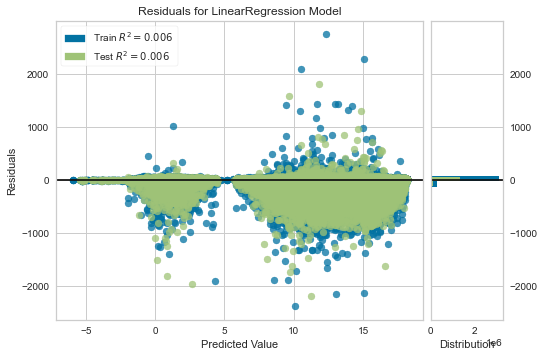

In [74]:
plot_model(tuned_lr)

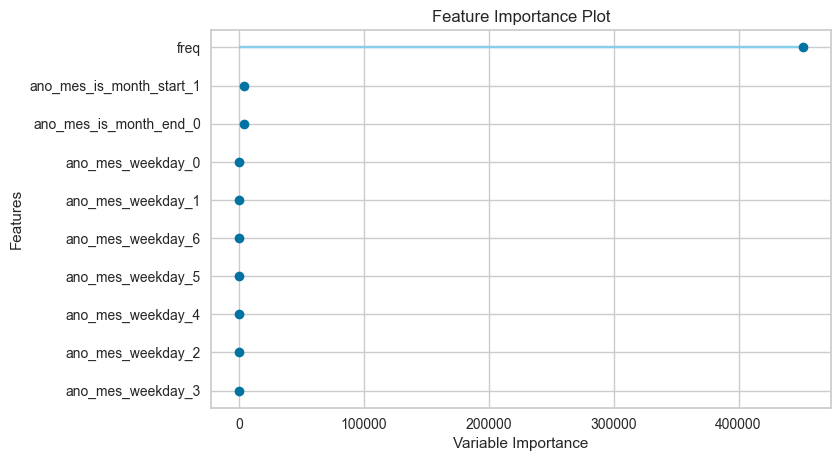

In [75]:
plot_model(tuned_lr, plot='feature')

In [76]:
predict_model(tuned_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,18.8700,1536.3654,39.1965,0.0062,1.7390,113.5462


In [77]:
final_lr = finalize_model(tuned_lr)

In [78]:
print(final_lr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


In [79]:
df_2024_r = predict_model(final_lr, data=df_predictions)

df_2024_r.rename(columns={'Label': 'receita_spread'})

,id,periodo,freq,ano_mes,grupos,receita_spread
0,102634,202001,8.125074e-07,2020-01-01,4,11.558350
1,102634,202002,8.125074e-07,2020-02-01,4,13.738571
2,102634,202003,8.125074e-07,2020-03-01,4,15.044701
3,102634,202004,8.125074e-07,2020-04-01,4,12.617111
4,102634,202005,8.125074e-07,2020-05-01,4,13.829514
...,...,...,...,...,...,...
20116927,2075258791292559698,202408,2.031269e-06,2024-08-01,3,14.764503
20116928,2075258791292559698,202409,2.031269e-06,2024-09-01,3,15.443359
20116929,2075258791292559698,202410,2.031269e-06,2024-10-01,3,14.906006
20116930,2075258791292559698,202411,2.031269e-06,2024-11-01,3,16.530914


In [80]:
df_predictions

,id,periodo,freq,ano_mes,grupos
0,102634,202001,8.125074e-07,2020-01-01,4
1,102634,202002,8.125074e-07,2020-02-01,4
2,102634,202003,8.125074e-07,2020-03-01,4
3,102634,202004,8.125074e-07,2020-04-01,4
4,102634,202005,8.125074e-07,2020-05-01,4
...,...,...,...,...,...
20116927,2075258791292559698,202408,2.031269e-06,2024-08-01,3
20116928,2075258791292559698,202409,2.031269e-06,2024-09-01,3
20116929,2075258791292559698,202410,2.031269e-06,2024-10-01,3
20116930,2075258791292559698,202411,2.031269e-06,2024-11-01,3


In [83]:
exp_cpl = setup(data=df_transacional[['freq','custo_perda_liquida','ano_mes','grupos']], target='custo_perda_liquida', session_id=123) 

,Description,Value
0,session_id,123
1,Target,custo_perda_liquida
2,Original Data,"(4923032, 4)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3446122, 32)"


In [84]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,29.1528,14761.9590,121.4988,0.0015,1.9699,9858090795008.0000
1,28.8389,15990.8896,126.4551,0.0012,1.9689,50851360014336.0000
2,28.8477,15390.2314,124.0574,0.0016,1.9695,14300724854784.0000
3,29.0527,15778.5303,125.6126,0.0013,1.9656,13729934606336.0000
4,28.7831,15444.9609,124.2778,0.0016,1.9687,8653068304384.0000
5,28.9415,15353.4170,123.9089,0.0016,1.9665,13381775917056.0000
6,28.2251,13028.8457,114.1440,0.0017,1.9655,7570397331456.0000
7,28.7079,18283.8496,135.2178,0.0011,1.9637,6334991826944.0000
8,28.8372,13991.0879,118.2839,0.0016,1.9664,8615632044032.0000
9,28.6187,16031.9404,126.6173,0.0014,1.9686,9377076477952.0000


In [85]:
tuned_lr = tune_model(lr, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,29.1561,14761.9746,121.4989,0.0015,1.9702,9865320726528.0000
1,28.8414,15990.8906,126.4551,0.0012,1.9690,50868741210112.0000
2,28.8463,15390.1309,124.0570,0.0016,1.9695,14285866532864.0000
3,29.0800,15778.4424,125.6123,0.0013,1.9674,13752363646976.0000
4,28.7669,15444.8428,124.2773,0.0016,1.9678,8629224210432.0000
5,28.9428,15353.4395,123.9090,0.0016,1.9665,13390497972224.0000
6,28.2316,13028.8350,114.1439,0.0017,1.9661,7571115606016.0000
7,28.7454,18283.6758,135.2171,0.0011,1.9662,6358175318016.0000
8,28.8342,13990.9912,118.2835,0.0016,1.9662,8581732630528.0000
9,28.6106,16031.8818,126.6171,0.0014,1.9684,9368688918528.0000


In [86]:
predict_model(tuned_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,28.7239,15129.0029,123.0000,0.0015,1.9686,8571704049664.0000


In [87]:
final_lr = finalize_model(tuned_lr)

In [88]:
df_2024_r_cpl = predict_model(final_lr, data=df_2024_r)

df_2024_r_cpl.rename(columns={'Label': 'custo_perda_liquida'})

,id,periodo,freq,ano_mes,grupos,custo_perda_liquida
0,102634,202001,8.125074e-07,2020-01-01,4,18.568848
1,102634,202002,8.125074e-07,2020-02-01,4,12.636963
2,102634,202003,8.125074e-07,2020-03-01,4,16.532227
3,102634,202004,8.125074e-07,2020-04-01,4,19.102051
4,102634,202005,8.125074e-07,2020-05-01,4,18.071533
...,...,...,...,...,...,...
20116927,2075258791292559698,202408,2.031269e-06,2024-08-01,3,21.788818
20116928,2075258791292559698,202409,2.031269e-06,2024-09-01,3,19.187988
20116929,2075258791292559698,202410,2.031269e-06,2024-10-01,3,16.171143
20116930,2075258791292559698,202411,2.031269e-06,2024-11-01,3,12.211914


In [89]:
exp_rs = setup(data=df_transacional[['freq','receita_servicos','ano_mes','grupos']], target='receita_servicos', session_id=123) 

,Description,Value
0,session_id,123
1,Target,receita_servicos
2,Original Data,"(4923032, 4)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3446122, 32)"


In [90]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.9509,58.1953,7.6286,0.0243,1.2074,2.9950
1,4.9326,53.6014,7.3213,0.0265,1.2060,2.8327
2,4.9304,54.0682,7.3531,0.0265,1.2064,3.2020
3,4.9221,54.4904,7.3818,0.0254,1.2056,2.9953
4,4.9383,53.0541,7.2838,0.0256,1.2049,2.9517
5,4.9348,56.3668,7.5078,0.0254,1.2063,3.0980
6,4.9371,54.6627,7.3934,0.0257,1.2058,2.9191
7,4.9399,55.0060,7.4166,0.0256,1.2057,3.1102
8,4.9245,54.0435,7.3514,0.0263,1.2050,2.9943
9,4.9553,58.9977,7.6810,0.0244,1.2062,3.1528


In [91]:
tuned_lr = tune_model(lr, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.9499,58.1955,7.6286,0.0243,1.2071,2.9931
1,4.9325,53.6014,7.3213,0.0265,1.2059,2.8325
2,4.9305,54.0682,7.3531,0.0265,1.2064,3.2021
3,4.9232,54.4906,7.3818,0.0254,1.2059,2.9979
4,4.9381,53.0539,7.2838,0.0256,1.2049,2.9512
5,4.9356,56.3672,7.5078,0.0254,1.2065,3.0999
6,4.9368,54.6624,7.3934,0.0257,1.2057,2.9190
7,4.9398,55.0054,7.4166,0.0257,1.2056,3.1093
8,4.9248,54.0435,7.3514,0.0263,1.2051,2.9947
9,4.9556,58.9976,7.6810,0.0244,1.2063,3.1535


In [92]:
predict_model(tuned_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.9363,56.4411,7.5127,0.0250,1.2070,3.0168


In [93]:
final_lr = finalize_model(tuned_lr)

In [94]:
df_2024_r_cpl_rs = predict_model(final_lr, data=df_2024_r_cpl)

df_2024_r_cpl_rs.rename(columns={'Label': 'receita_servicos'})

,id,periodo,freq,ano_mes,grupos,receita_servicos
0,102634,202001,8.125074e-07,2020-01-01,4,7.393250
1,102634,202002,8.125074e-07,2020-02-01,4,6.576416
2,102634,202003,8.125074e-07,2020-03-01,4,6.313782
3,102634,202004,8.125074e-07,2020-04-01,4,7.264618
4,102634,202005,8.125074e-07,2020-05-01,4,6.233948
...,...,...,...,...,...,...
20116927,2075258791292559698,202408,2.031269e-06,2024-08-01,3,6.085327
20116928,2075258791292559698,202409,2.031269e-06,2024-09-01,3,5.882629
20116929,2075258791292559698,202410,2.031269e-06,2024-10-01,3,6.229675
20116930,2075258791292559698,202411,2.031269e-06,2024-11-01,3,5.869812


In [115]:
df_final = df_2024_r.copy()
df_final.rename(columns={'Label': 'receita_spread'},inplace=True)

df_final['custo_perda_liquida'] = df_2024_r_cpl['Label']
df_final['receita_servicos'] = df_2024_r_cpl_rs['Label']

df_final.head()

,id,periodo,freq,ano_mes,grupos,receita_spread,custo_perda_liquida,receita_servicos,custo_impostos,custos,margem_operacional
0,102634,202001,8.125074e-07,2020-01-01,4,11.558350,18.568848,7.393250,1.011777,6.3,-6.929025
1,102634,202002,8.125074e-07,2020-02-01,4,13.738571,12.636963,6.576416,1.055567,6.3,0.322457
2,102634,202003,8.125074e-07,2020-03-01,4,15.044701,16.532227,6.313782,1.096878,6.3,-2.570622
3,102634,202004,8.125074e-07,2020-04-01,4,12.617111,19.102051,7.264618,1.050867,6.3,-6.571189
4,102634,202005,8.125074e-07,2020-05-01,4,13.829514,18.071533,6.233948,1.036886,6.3,-5.344958


In [116]:
df_final['custo_impostos'] = df_final['receita_spread'] * 0.045 + df_final['receita_servicos'] * 0.0665

In [117]:
df_final['custos'] = 6.3

In [119]:
df_final['margem_operacional'] = df_final.receita_spread - df_final.custo_perda_liquida + df_final.receita_servicos - df_final.custo_impostos - df_final.custos

In [120]:
df_final.head()

,id,periodo,freq,ano_mes,grupos,receita_spread,custo_perda_liquida,receita_servicos,custo_impostos,custos,margem_operacional
0,102634,202001,8.125074e-07,2020-01-01,4,11.558350,18.568848,7.393250,1.011777,6.3,-6.929025
1,102634,202002,8.125074e-07,2020-02-01,4,13.738571,12.636963,6.576416,1.055567,6.3,0.322457
2,102634,202003,8.125074e-07,2020-03-01,4,15.044701,16.532227,6.313782,1.096878,6.3,-2.570622
3,102634,202004,8.125074e-07,2020-04-01,4,12.617111,19.102051,7.264618,1.050867,6.3,-6.571189
4,102634,202005,8.125074e-07,2020-05-01,4,13.829514,18.071533,6.233948,1.036886,6.3,-5.344958


Vou dropar essas colunas pois elas não estavam no arquivo 'ml_predictions.csv', mas caso deseja usá-las novamente, basta comentar a linha abaixo.


In [121]:
df_final.drop(columns = ['freq','ano_mes','grupos'], inplace=True)

In [127]:
df_final['id']= df_final['id'].astype(str)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20116932 entries, 0 to 20116931
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   periodo              int64  
 2   receita_spread       float32
 3   custo_perda_liquida  float32
 4   receita_servicos     float32
 5   custo_impostos       float64
 6   custos               float64
 7   margem_operacional   float64
dtypes: float32(3), float64(3), int64(1), object(1)
memory usage: 997.6+ MB


In [128]:
df_final.head()

,id,periodo,receita_spread,custo_perda_liquida,receita_servicos,custo_impostos,custos,margem_operacional
0,102634,202001,11.558350,18.568848,7.393250,1.011777,6.3,-6.929025
1,102634,202002,13.738571,12.636963,6.576416,1.055567,6.3,0.322457
2,102634,202003,15.044701,16.532227,6.313782,1.096878,6.3,-2.570622
3,102634,202004,12.617111,19.102051,7.264618,1.050867,6.3,-6.571189
4,102634,202005,13.829514,18.071533,6.233948,1.036886,6.3,-5.344958


In [131]:
df_final.to_csv('df_final.csv', decimal='.', sep=';', encoding='utf-8')